# Hawai'i

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
import cmocean
import ipywidgets as widgets
from IPython.display import display, IFrame, clear_output
from fatiando.gravmag import normal_gravity
# Load our custom helper functions from helpers.py
from helpers import plot_field, plot_hawaii_data, minmax

/home/leo/miniconda3/envs/case-studies-gravity/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/leo/miniconda3/envs/case-studies-gravity/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Look at in Google Maps

In [2]:
IFrame(width="100%", height="600px", 
       src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d5916036.911229154!2d-157.7151201!3d20.5932929!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413401199263")

## Gravity and Topography

In [3]:
data = xr.open_dataset('data/hawaii-gravity.nc')
data

<xarray.Dataset>
Dimensions:           (latitude: 301, longitude: 301)
Coordinates:
  * latitude          (latitude) float32 13.0 13.05 13.1 13.15 13.2 13.25 ...
  * longitude         (longitude) float32 -165.0 -164.95 -164.9 -164.85 ...
Data variables:
    gravity_earth     (latitude, longitude) float32 ...
    h_over_geoid      (latitude, longitude) float32 ...
    geoid             (latitude, longitude) float32 ...
    topography_grd    (latitude, longitude) float32 ...
    h_over_ellipsoid  (latitude, longitude) float32 ...

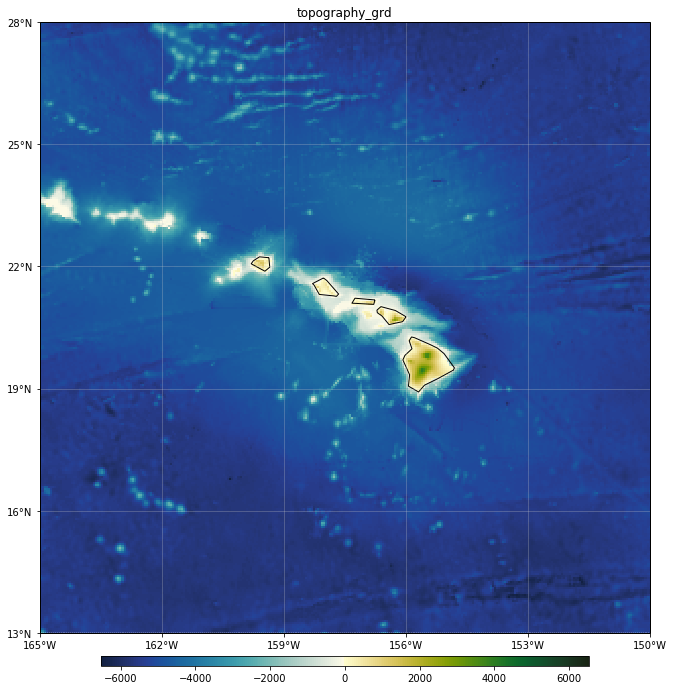

In [5]:
plot_hawaii_data(data, 'topography_grd', cmap=cmocean.cm.delta)

## Normal Gravity

In [9]:
data['normal_gravity'] = normal_gravity.gamma_closed_form(data.latitude, data.h_over_ellipsoid)

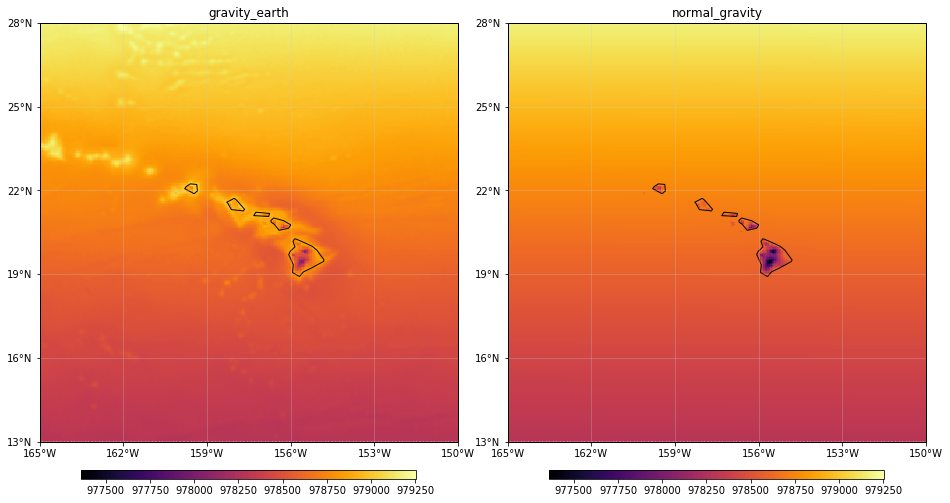

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), 
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
fields = ['gravity_earth', 'normal_gravity']
cmaps = ['inferno', 'inferno']
kwargs = minmax(data, fields)
for field, ax, cmap in zip(fields, axes.ravel(), cmaps):
    plot_field(ax, data, field, cmap, cb_pad=0.05, cb_aspect=40, **kwargs)
plt.tight_layout(pad=0)

## Gravity Disturbance

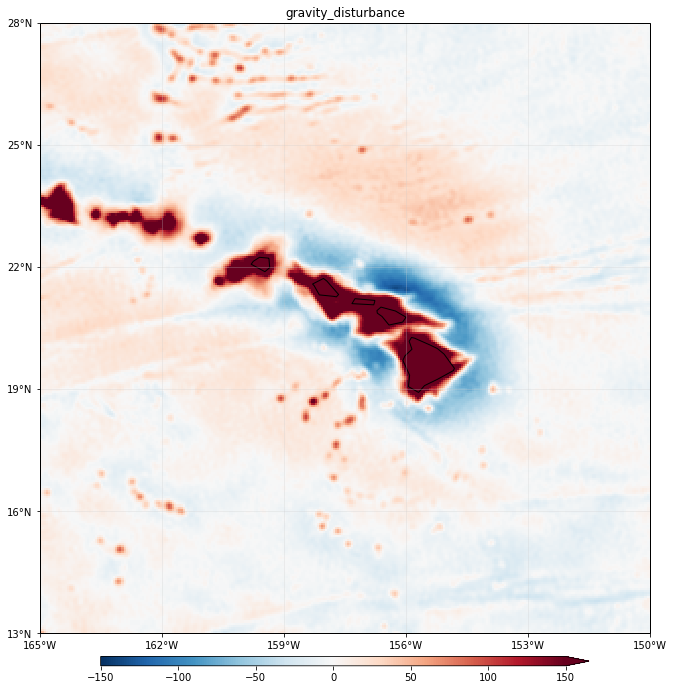

In [11]:
data['gravity_disturbance'] = data.gravity_earth - data.normal_gravity

plot_hawaii_data(data, 'gravity_disturbance', cmap='RdBu_r', vmin=-150, vmax=150)

In [12]:
class ProfileSelector(object):
    def __init__(self, data, fields):
        self.data = data
        self.fields = fields
        self._plot_initiated = False
        
    def _figure_setup(self):
        if not self._plot_initiated:

            
            self.fig, axes = plt.subplots(2, 1, sharex=True, figsize=(13, 7))
            self.ax_data, self.ax_topo = axes
            
            self._topo_base = -10000
            
            ylim_topo = [self._topo_base, self.data.topography_grd.max()*1.1]
            ylim_data = list(sorted(minmax(self.data, self.fields).values()))

            self.ax_data.set_ylim(ylim_data)
            self.ax_data.set_ylabel('mGal')
            self.ax_topo.set_ylim(ylim_topo)
            self.ax_topo.set_ylabel('Tropography (m)')  
            self.ax_data.grid(True)

            self._data_lines = {}
            for field in self.fields:
                self._data_lines[field], = self.ax_data.plot(
                    [0], [0], '-', label=field)
            self.ax_data.legend(loc='upper right')

            self._water_fill = None
            self._topo_fill = None
            
            #plot_field(self.ax_map, self.data, fields[0], cb_pad=0.05, cb_aspect=40)
            
            plt.tight_layout(pad=0)
            
            self._plot_initiated = True

    def plot(self, location, dimension):
        self._figure_setup()
        # Get the name of the other dimension
        dim_comp = set(self.data.dims).difference({dimension}).pop()

        x = self.data[dimension]
        xlim = [x.min(), x.max()]      
        profile = self.data.loc[{dim_comp: location}]
        
        for field in self.fields:
            self._data_lines[field].set_data(x, profile[field])
                    
        if self._topo_fill is not None:
            self._topo_fill.remove()
        if self._water_fill is not None:
            self._water_fill.remove()
        self._water_fill = self.ax_topo.fill_between(xlim, [0, 0], self._topo_base, color='#2780E3')
        self._topo_fill = self.ax_topo.fill_between(x, profile.topography_grd, self._topo_base, color='#333333')
        
        self.ax_data.set_xlim(xlim)
        self.ax_topo.set_xlim(xlim)
        self.ax_topo.set_xlabel(dimension.capitalize())
        plt.show()
    
    def interact(self):
        profile_interval = 10
        
        options = self.data.longitude.values.tolist()[::profile_interval]
        mid = options[len(options)//2]
        dimension = 'longitude'
        
        slider = widgets.SelectionSlider(options=options, value=mid, 
                                         layout=widgets.Layout(width="50%"))
        slider_label = widgets.Label("{} value".format(dimension.capitalize()))
        dimension_chooser = widgets.Dropdown(
            options=self.data.dims.keys(), value=data.dims.keys()[0], 
            description="Profile along")
        
        def displayer(location, dimension):
            self.plot(location, dimension)
            display(self.fig)
            
        def handle_dimension_change(change):
            dim_comp = set(self.data.dims).difference({change.new}).pop()
            slider_label.value = "{} value".format(dim_comp.capitalize())
            options = self.data[dim_comp].values.tolist()[::profile_interval]
            slider.options = options
            slider.value = options[len(options)//2]
            
        dimension_chooser.observe(handle_dimension_change, names='value')
            
        output = widgets.interactive_output(displayer, {'location': slider, 'dimension': dimension_chooser})
        layout = widgets.VBox([widgets.HBox([dimension_chooser, slider_label, slider]), output])
        
        # For some reason, calling _figure_setup inserts a plot in the output
        # Call clear_output to get rid of it.
        with output:
            clear_output(wait=True)
            display(self.fig)
        
        return layout

In [13]:
ProfileSelector(data, ['gravity_disturbance']).interact()

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdQcm9maWxlIGFsb25nJywgb3B0aW9ucz0odSdsYXRpdHVkZScsIHUnbG9uZ2l0dWRlJyksIHZhbHXigKY=


## Bouguer correction

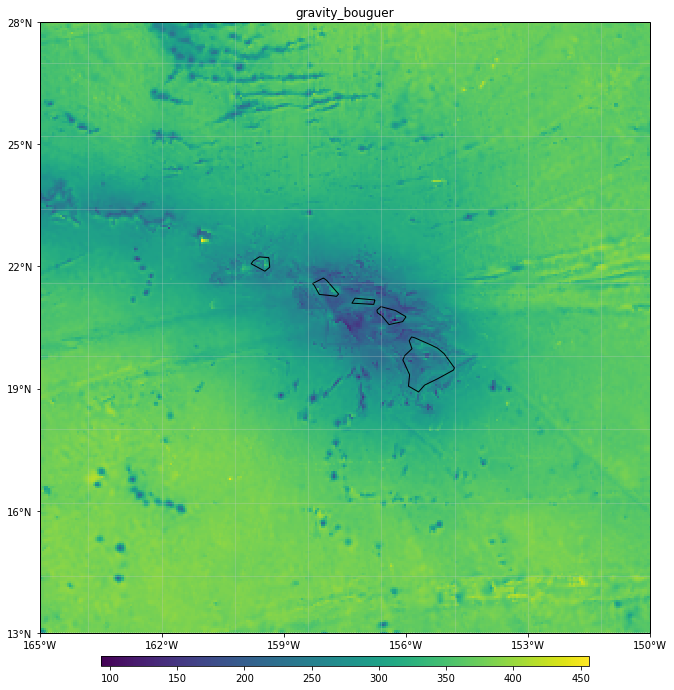

In [93]:
data['gravity_bouguer'] = data.gravity_disturbance - normal_gravity.bouguer_plate(data.topography_grd)

plot_hawaii_data(data, 'gravity_bouguer')

## Questions

* Why is the swell not present in the disturbance?
* Why is the Bouguer smaller over the islands?
* Why do some small trenches have big gravity lows (sediments)?